#### Basic stuff before all

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="root",
  database="wapo"
)

mycursor = mydb.cursor()

mycursor.execute("SHOW TABLES")

for x in mycursor:
  print(x)

#query = "SELECT * FROM reports WHERE id IN "+buf
#df_questions = pd.read_sql(query, con=mydb)

resultFile ="~/git/WapoDataMining/results/mlt_allfilter_content40_title10.txt"


(u'reports',)


In [2]:
# misleading function name but returns dataframe 
# for question, relevance judgement 
# and my top 5 answers

def heavyInspect(topicId,resultFile,questions_df,answers_df,scoreThreshold,myResultCount=5):
    # read the result file
    myresult_df = pd.read_csv(resultFile, header=None, delim_whitespace=True)
    #print(myresult_df)
    # extract first 5 cols of given topic id
    myresult_df = myresult_df.loc[myresult_df[0]==topicId][0:myResultCount]
    
    my_top_id = myresult_df[2].values.tolist()
    #print(my_top_id)
    #print(my_top_5_id[0])
    
    # construct sql query and get result as a df for the ids
    buf = "("
    l = len(my_top_id)
    for i in range(len(my_top_id)):
        buf+="'"+my_top_id[i]+"'"
        l = l-1
        if(l!=0):
            buf+=","

    buf+=")"
    #print(buf)
    
    query = "SELECT * FROM reports WHERE id IN "+buf
    myresult_df = pd.read_sql(query, con=mydb)
    
    question_df = questions.loc[questions["topic_no"]==topicId]
    
    answers_df = answers.loc[(answers["score"]>=scoreThreshold) & (answers["topic_no"]==topicId)]
    
    return myresult_df,question_df,answers_df
    


In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
questions = pd.read_csv("questions.csv")
answers = pd.read_csv("answers.csv")
#questions

In [16]:

# look at all the time deltas between question and 
# gold standard results

def get_time_diff_list(questions,answers):
    diff_list = []
    
    #iterate through
    for topic_no in questions["topic_no"].values:
        
        myresult_df,question_df,actual_result_df = heavyInspect(topic_no,resultFile,questions,answers,2)
        #print(actual_result_df)
        query_date = datetime.fromtimestamp((float(question_df["date"].values[0])/1000))
        result_dates = actual_result_df["date"].values
        
        for result_date in result_dates:
            rd = datetime.fromtimestamp((float(result_date)/1000))
            diff_list.append(rd-query_date)
    dateExtracter = lambda x: x.days
    date_deltas = list(map(dateExtracter,diff_list))
    
    return date_deltas

l = get_time_diff_list(questions,answers)

In [32]:
#for topic_no see the duplicate results in qrel 
topic_no = 393
myresult_df,question_df,actual_result_df = heavyInspect(topic_no,resultFile,questions,answers,2)

actual_result_df[actual_result_df.duplicated(["title"],keep=False)][["title","author"]]


,title,author
253,A terminally ill woman had one rule at her end-of-life party: No crying,Lindsey Bever
336,A terminally ill woman had one rule at her end-of-life party: No crying,Lindsey Bever
1796,Beyond Brittany Maynard: Who is choosing to die with dignity,Jason Millman
2661,Beyond Brittany Maynard: Who is choosing to die with dignity,Jason Millman
3061,A terminally ill woman had one rule at her end-of-life party: No crying,Lindsey Bever
4906,"Brittany Maynard, as promised, ends her life at 29",Lindsey Bever
8133,"Brittany Maynard, as promised, ends her life at 29",Lindsey Bever


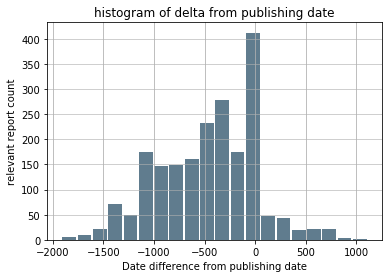

In [17]:


diff = pd.Series(l)
diff.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('histogram of delta from publishing date')
plt.xlabel('Date difference from publishing date')
plt.ylabel('relevant report count')
plt.grid(axis='y', alpha=0.75)

In [7]:
# return for each topic (topic_id,relevant_report_on_or_before, total_rel_report)

def get_time_diff_list_per_topic(questions,answers):
    ret = []
    
    #iterate through
    for topic_no in questions["topic_no"].values:
        diff_list = []
        on_or_before = 0
        after = 0
        myresult_df,question_df,actual_result_df = heavyInspect(topic_no,resultFile,questions,answers,0)
        #print(actual_result_df)
        query_date = datetime.fromtimestamp((float(question_df["date"].values[0])/1000))
        result_dates = actual_result_df["date"].values
        
        for result_date in result_dates:
            rd = datetime.fromtimestamp((float(result_date)/1000))
            diff_list.append(rd-query_date)
        
        dateExtracter = lambda x: x.days
        date_deltas = list(map(dateExtracter,diff_list))
        #print("*****")
        #print(topic_no)
        for delta in date_deltas:
            
            if(delta>0):
                after = after+1
            else:
                on_or_before = on_or_before+1
            
            
            #print(after)
            #print(delta)
        total = on_or_before+after
        
        ret.append((topic_no,on_or_before,total))
    
    return ret

ll = get_time_diff_list_per_topic(questions,answers)
#ll



In [8]:
question_list = questions[["topic_no","title"]].values
for i in range(len(question_list)):
    up = float(ll[i][1])
    down = float(ll[i][2])
    ans = -1
    if(down!=0):
        ans = up/down
    if(ans<=0.6):
        print(question_list[i][1],ans)
    

('Cuba has outsized role in Venezuela as Chavez fights cancer', 0.5342465753424658)
('Defining cool, from Walt Whitman and James Dean to Steve Jobs and Tony Hawk', 0.32228915662650603)
('Motorized exoskeleton for paralyzed people approved by FDA', 0.5267857142857143)
('Jeffrey Bezos, Washington Post\xe2\x80\x99s next owner, aims for a new \xe2\x80\x98golden era\xe2\x80\x99 at the newspaper', 0.5153061224489796)
('North Korean \xe2\x80\x98traffic girl\xe2\x80\x99 may have won military award for saving Kim Jong Un poster', 0.25327510917030566)
('The Sony hack: Why would any outlet not report the sordid \xe2\x80\x94 and newsy \xe2\x80\x94 details?', 0.3605769230769231)
('Metro, local responders would jointly test radios under new plan', 0.3140495867768595)
('America is rapidly aging in a country built for the young', 0.5909090909090909)
('How bad for your eyes are computer screens?', 0.5245901639344263)
('Super Typhoon Vongfong explodes, becomes most intense storm on Earth in 2014', 0.365

In [9]:
myresult_df,question_df,actual_result_df = heavyInspect(321,resultFile,questions,answers,0)


#### Converting string date column to date 

In [10]:
myresult_df["date"].apply(lambda x : datetime.fromtimestamp(float(x)/1000))
question_df["date"] = question_df["date"].apply(lambda x : datetime.fromtimestamp(float(x)/1000))
actual_result_df["date"] = actual_result_df["date"].apply(lambda x : datetime.fromtimestamp(float(x)/1000))

/home/i3/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/i3/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Checking what percent of results is before and after the query report date

In [11]:
#actual_result_df["date"]
question_df["id"].values

array(['9171debc316e5e2782e0d2404ca7d09d'], dtype=object)

In [12]:
cols = ["title","content","date"]

question_df[cols]

title  \
28  Despite a big year for women in politics, national legislatures are still dominated by men   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [13]:
cols3 = ["title","content","score","date"]
#actual_result_df[cols3].sort_values(by="score",ascending=False)[0:5]
top5 = actual_result_df.sort_values(by="score",ascending=False)[0:5]
top5[cols3]

title  \
7047  Rwanda is beating the United States in gender equality                                     
4892  So the U.K. has its second female prime minister. What policies put more women in power?   
6473  Why quotas are needed to achieve gender equality                                           
3881  Does Western pressure for gender equality help?                                            
40    Time to celebrate women’s gains in the U.K. election? Not so fast.                         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [14]:
cols2 = ["title","content","date"]
myresult_df[cols2]

title  \
0  At Davos, Sheryl Sandberg’s silence on politics and quotas says it all                              
1  Despite a big year for women in politics, national legislatures are still dominated by men          
2  The changing face of women’s political participation in the Middle East                             
3  So the U.K. has its second female prime minister. What policies put more women in power?            
4  Twenty years after the most important U.N. conference on women, what – if anything – has changed?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
p = pd.merge(actual_result_df,myresult_df, on='id', how='inner')
cols4 = ["title_x","content_x","score","date_x"]
p[cols4]

title_x  \
0  At Davos, Sheryl Sandberg’s silence on politics and quotas says it all                              
1  Despite a big year for women in politics, national legislatures are still dominated by men          
2  The changing face of women’s political participation in the Middle East                             
3  So the U.K. has its second female prime minister. What policies put more women in power?            
4  Twenty years after the most important U.N. conference on women, what – if anything – has changed?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            